2440021451 - Oei Angela Christabel Gunawan

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
from scipy import ndimage
from skimage.feature import corner_peaks

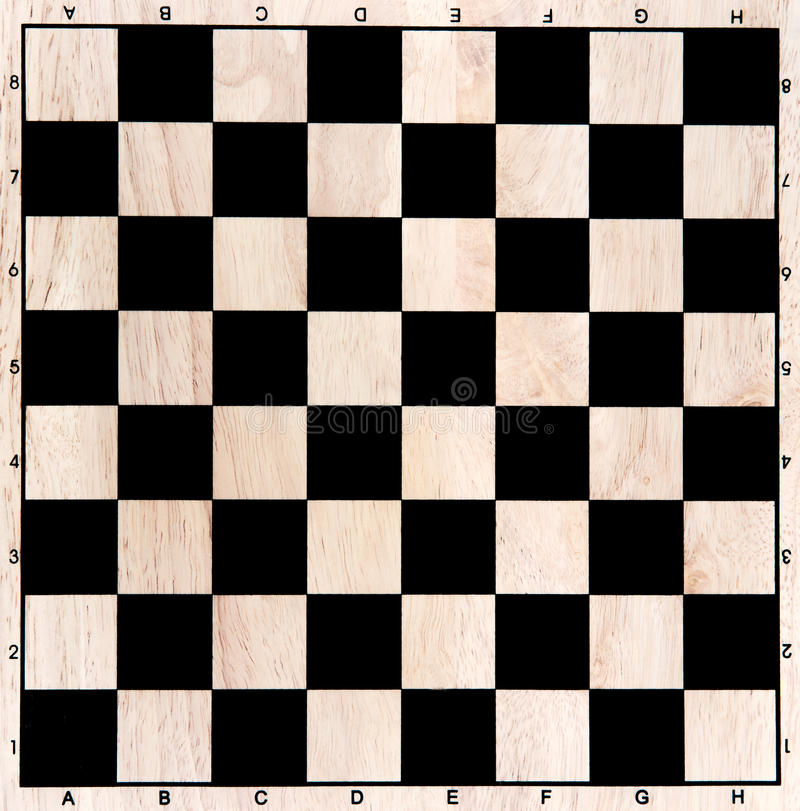

In [37]:
image = cv2.imread('image.jpg')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(image)

#1. Calculate Gaussian derivatives

For this, we will be using Sobel operators to find these derivatives.

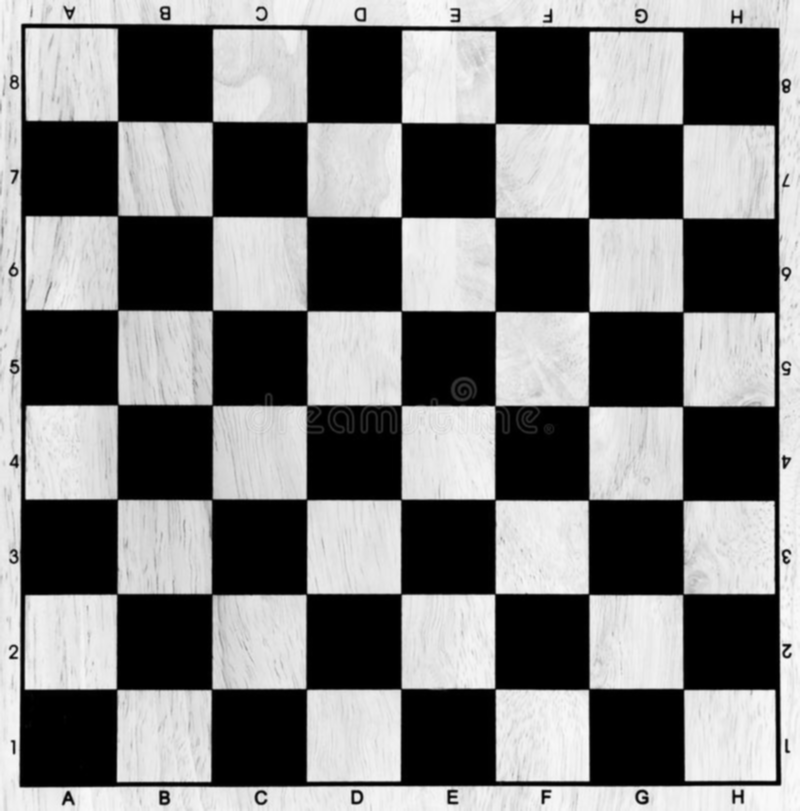

In [38]:
# Before applying Sobel filter, apply Gaussian filter first
img_gaussian = cv2.GaussianBlur(img_gray, (3, 3), 0)
cv2_imshow(img_gaussian)

In [39]:
mask_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], np.float32)

mask_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
], np.float32)

# Lakukan konvolusi dengan sobel operator
dx = ndimage.filters.convolve(img_gaussian, mask_x)
dy = ndimage.filters.convolve(img_gaussian, mask_y)

# Dapatkan dx kuadrat, dy kuadrat, dan dx * dy
dx2 = np.square(dx)
dy2 = np.square(dy)
dxy = dx * dy

#2. Compute second moment matrix M in a Gaussian window around each pixel

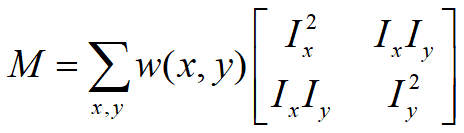

#3.	Compute corner response function R

In [95]:
h, w = img_gaussian.shape

# Tentukan window size 
window_size = 5

# Ini ukuran window size / 2, karena window akan mengelilingi pixel tengah
offset = int(window_size/2)

# Untuk hitung corner response function nanti
alpha = 0.06

# Untuk menyimpan value response function
matrix_R = np.zeros((h, w))

for y in range(offset, h-offset):
  for x in range(offset, w-offset):
    # Hitung sum of Ixx, Ixy, dan Iyy dalam window yg dibentuk
    Ixx = np.sum(dx2[y-offset:y+1+offset, x-offset:x+1+offset])
    Iyy = np.sum(dy2[y-offset:y+1+offset, x-offset:x+1+offset])
    Ixy = np.sum(dxy[y-offset:y+1+offset, x-offset:x+1+offset])

    # Dapatkan M yang sama dgn [[Ix2 IxIy], [IxIy, Iy2]]
    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])

    # Hitung corner response function R
    det = np.linalg.det(M)
    trace = np.matrix.trace(M)
    R = det - alpha * (trace ** 2)
    matrix_R[y-offset, x-offset] = R

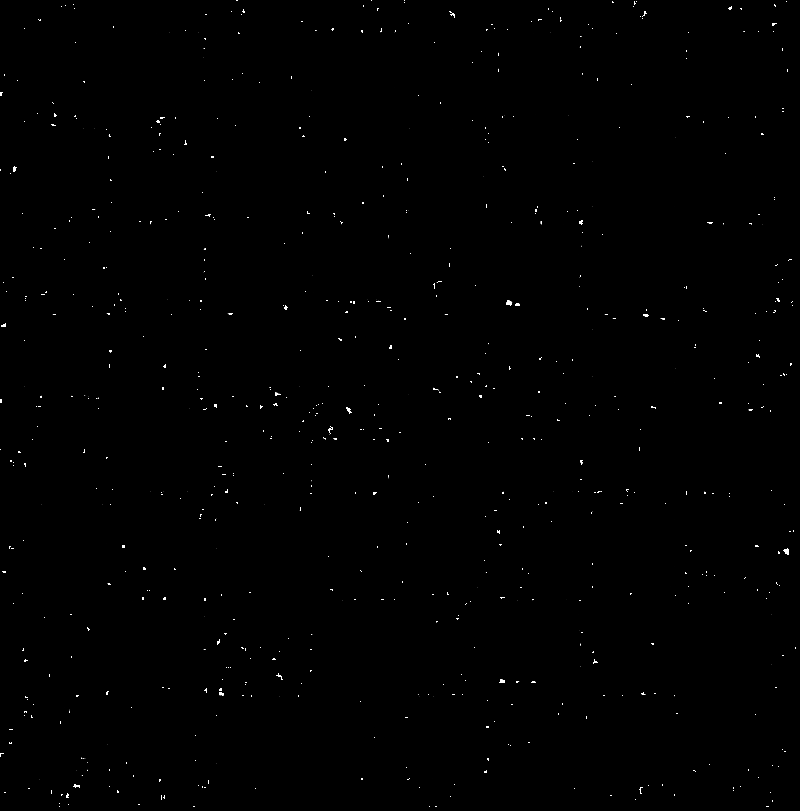

In [96]:
cv2_imshow(matrix_R)

#4. Threshold R

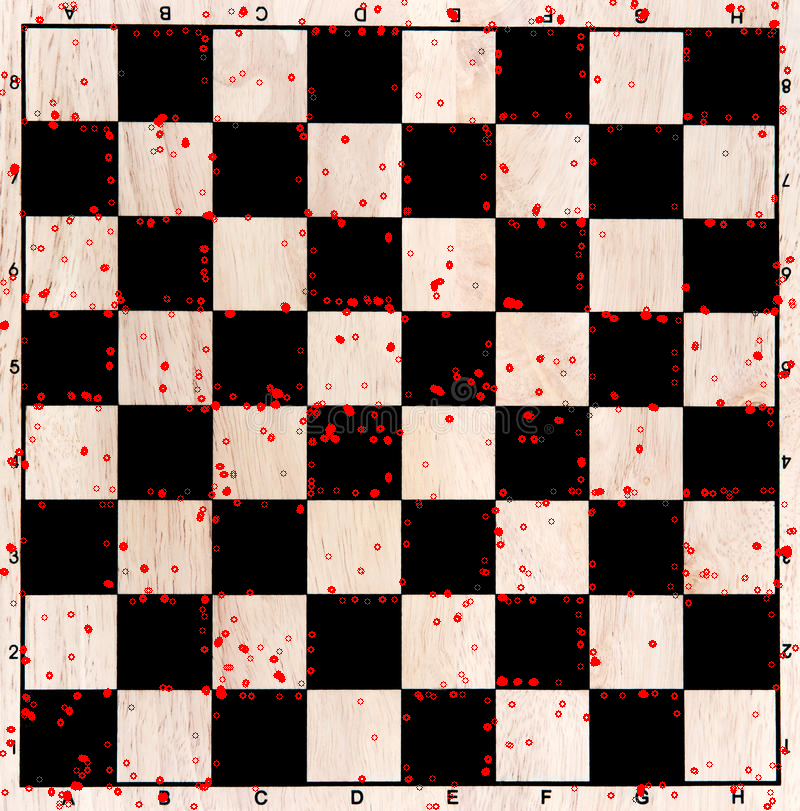

In [97]:
threshold = 0
img_r_thresh = image.copy()
thresh_R = np.zeros((h, w))

for y in range(offset, h-offset):
  for x in range(offset, w-offset):
    R = matrix_R[y, x]

    # Jika R > 0 maka corner. Jika R == 0 maka flat. Jika R < 0 maka edge.
    if R > threshold:
      # Gambar lingkaran di corner yang detected
      cv2.circle(img_r_thresh, (x, y), 3, (0, 0, 255))
      thresh_R[y, x] = R

cv2_imshow(img_r_thresh)

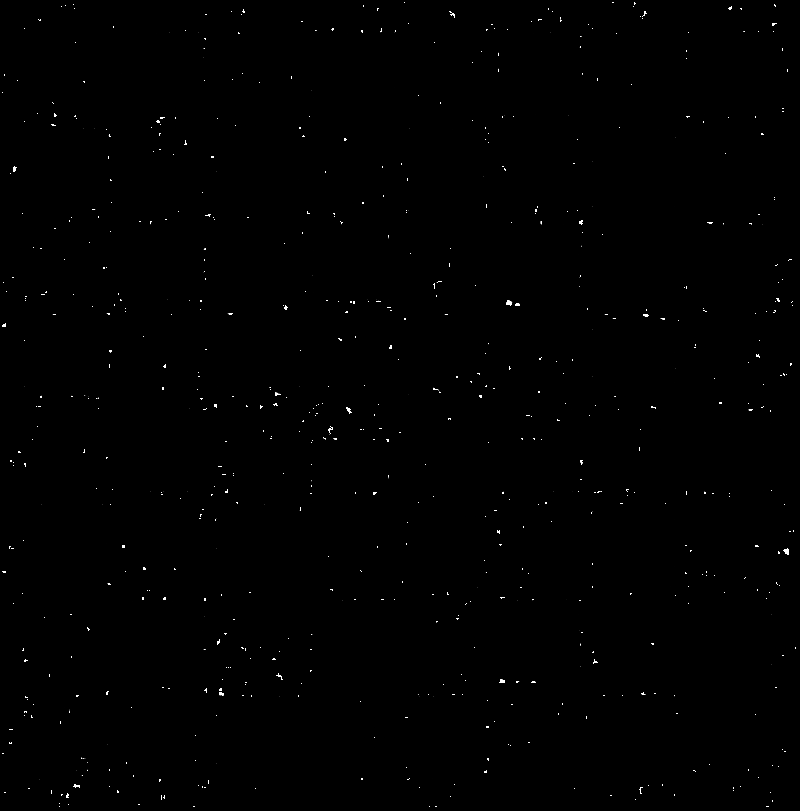

In [98]:
cv2_imshow(thresh_R)

#5. Find local maxima of response function (non-maximum suppression)

Local maximum in image defined as a point greater than its neighbors (in 3 × 3 or even 5 × 5 neighborhood)

In [99]:
new_matrix_R = thresh_R.copy()

shift_x = [-1, 0, 1, -1, 1, -1, 0, 1]
shift_y = [-1, -1, -1, 0, 0, 1, 1, 1]

for y in range(1, h-1):
  for x in range(1, w-1):
    local_max = 0

    # Cari R value paling tinggi dalam window 3x3
    for i in range(len(shift_x)): 
      sx = shift_x[i]
      sy = shift_y[i]
      
      if new_matrix_R[y+sy, x+sx] > local_max:
        local_max = new_matrix_R[y+sy, x+sx]
      else:
        # matikan
        new_matrix_R[y+sy, x+sx] = 0

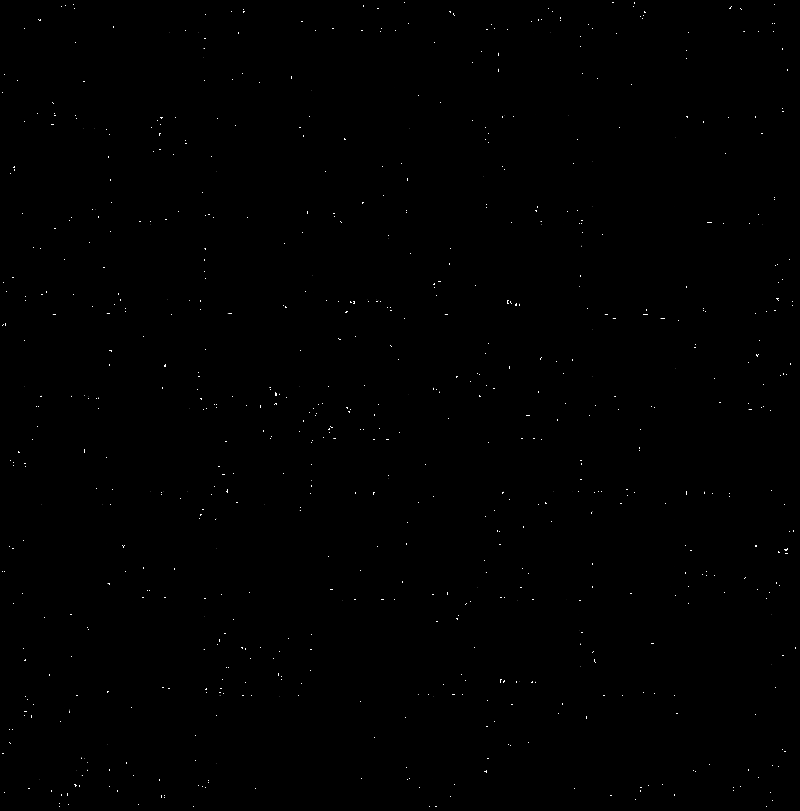

In [100]:
cv2_imshow(new_matrix_R)

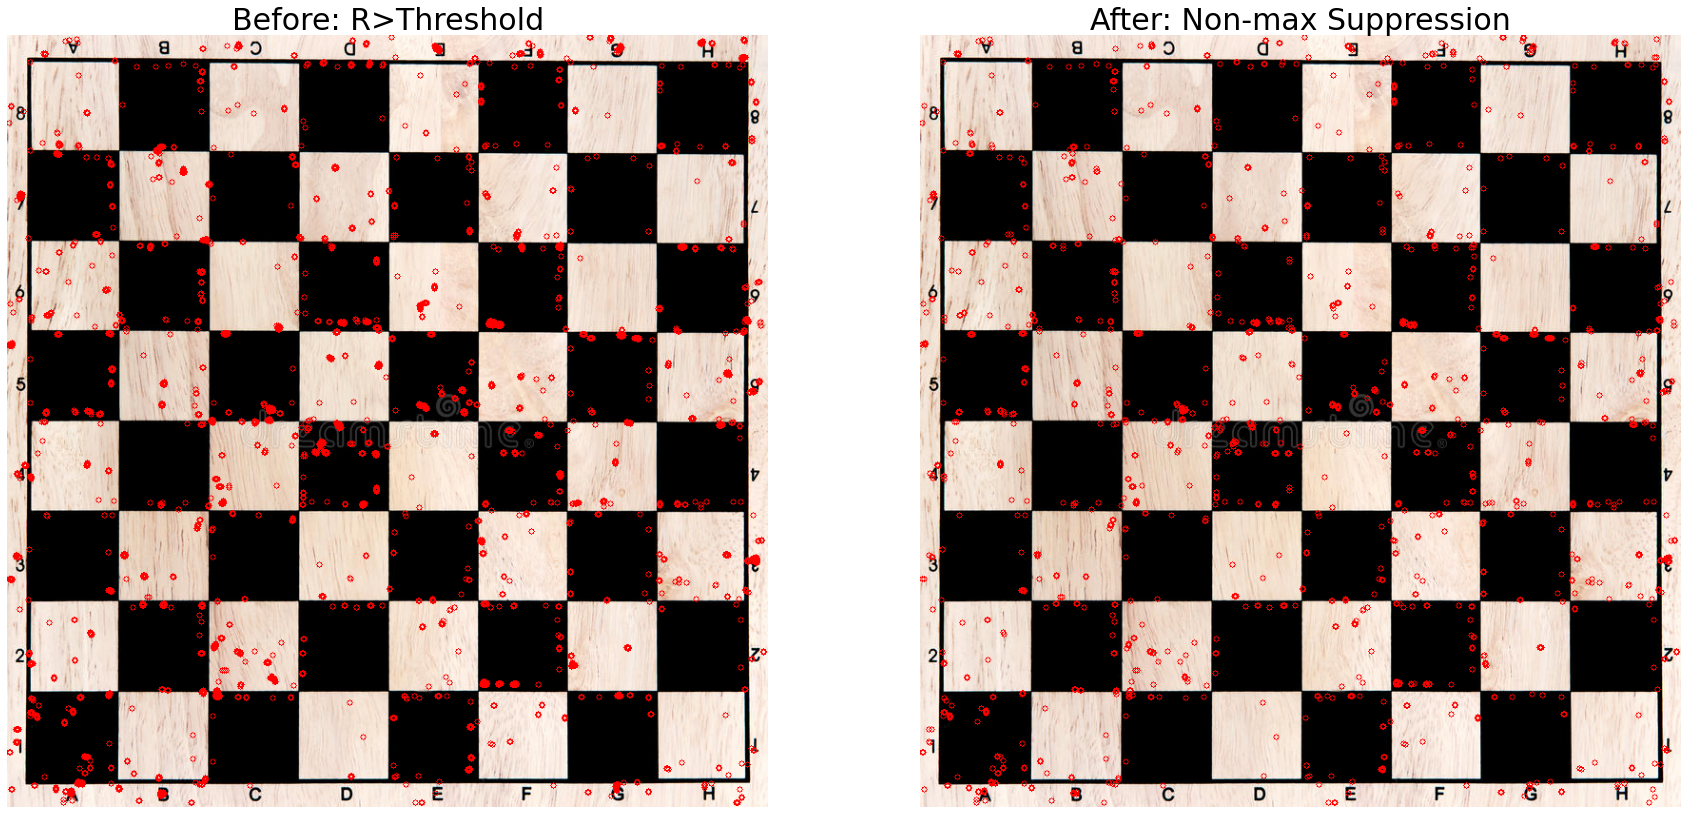

In [101]:
threshold = 0

result = image.copy()

for y in range(offset, h-offset):
  for x in range(offset, w-offset):
    # Pakai R value yang sudah diapply non-max suppression
    R = new_matrix_R[y, x]

    if R > threshold:
      # Gambar lingkaran di corner yang detected
      cv2.circle(result, (x, y), 3, (0, 0, 255))

plt.figure(figsize=(30, 18))

plt.subplot(121)
plt.imshow(cv2.cvtColor(img_r_thresh, cv2.COLOR_BGR2RGB))
plt.title('Before: R>Threshold', fontsize=30)
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('After: Non-max Suppression', fontsize=30)
plt.axis('off')

plt.show()